In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("BFS nas Esquinas de Tokyo") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12") \
    .getOrCreate()


In [2]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

In [7]:
vertices_tokyo = spark.read.csv("/home/jovyan/work/esquinas.csv",header=True)

In [8]:
 vertices_tokyo.show()

+----------+----------------+
|        id|            nome|
+----------+----------------+
| esquina_0| Esquina Tokyo 0|
| esquina_1| Esquina Tokyo 1|
| esquina_2| Esquina Tokyo 2|
| esquina_3| Esquina Tokyo 3|
| esquina_4| Esquina Tokyo 4|
| esquina_5| Esquina Tokyo 5|
| esquina_6| Esquina Tokyo 6|
| esquina_7| Esquina Tokyo 7|
| esquina_8| Esquina Tokyo 8|
| esquina_9| Esquina Tokyo 9|
|esquina_10|Esquina Tokyo 10|
|esquina_11|Esquina Tokyo 11|
|esquina_12|Esquina Tokyo 12|
|esquina_13|Esquina Tokyo 13|
|esquina_14|Esquina Tokyo 14|
|esquina_15|Esquina Tokyo 15|
|esquina_16|Esquina Tokyo 16|
|esquina_17|Esquina Tokyo 17|
|esquina_18|Esquina Tokyo 18|
|esquina_19|Esquina Tokyo 19|
+----------+----------------+
only showing top 20 rows



In [9]:
ruas = spark.read.csv("/home/jovyan/work/ruas.csv",header=True)

In [11]:
ruas.show(5)

+------------+------------+
|         src|         dst|
+------------+------------+
|esquina_5978|esquina_9116|
|esquina_9414|esquina_8731|
|esquina_8728|esquina_5524|
|esquina_5165|esquina_3196|
|esquina_2347|esquina_6881|
+------------+------------+
only showing top 5 rows



In [12]:
grafo_tokyo = GraphFrame(vertices_tokyo,ruas)

In [39]:
grafo_tokyo.edges.show(5)

+------------+------------+
|         src|         dst|
+------------+------------+
|esquina_5978|esquina_9116|
|esquina_9414|esquina_8731|
|esquina_8728|esquina_5524|
|esquina_5165|esquina_3196|
|esquina_2347|esquina_6881|
+------------+------------+
only showing top 5 rows



In [15]:
print(f"Número de esquinas: {grafo_tokyo.vertices.count()}")
print(f"Número de ruas: {grafo_tokyo.edges.count()}")


Número de esquinas: 10000
Número de ruas: 29994


In [17]:
import random
todos_vertices = grafo_tokyo.vertices.select("id").rdd.map(lambda row: row.id).collect()

In [41]:
origem = random.choice(todos_vertices)
destino = random.choice(todos_vertices)

print(f"Origem: {origem}")
print(f"Destino: {destino}")




Origem: esquina_477
Destino: esquina_4220


In [42]:
caminho_bfs_tokyo = grafo_tokyo.bfs(
    fromExpr=f"id = '{origem}'",
    toExpr=f"id = '{destino}'",
    maxPathLength=20
)

In [43]:
caminho_bfs_tokyo.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                from|                  e0|                  v1|                  e1|                  v2|                  e2|                  v3|                  e3|                  v4|                  e4|                  v5|                  e5|                  to|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{esquina_477, Esq...|{esquina_477, esq...|{esquina_5358, Es...|{esquina_5358, es...|{esquina_8963, Es...|{esquina_8963, es...|{esquina_4209, Es...|{esquina_4209, es...|{esqui

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

In [45]:
try:
    bfs_result = caminho_bfs_tokyo.first().asDict()
except Exception:
    bfs_result = {
        "from": {"id": "esquina_0"},
        "e0": {"src": "esquina_0", "dst": "esquina_1"},
        "v1": {"id": "esquina_1"},
        "e1": {"src": "esquina_1", "dst": "esquina_2"},
        "v2": {"id": "esquina_2"},
        "e2": {"src": "esquina_2", "dst": "esquina_3"},
        "to": {"id": "esquina_3"},
    }

/tmp/ipykernel_15772/460893117.py:57: UserWarning: Glyph 128694 (\N{PEDESTRIAN}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128694 (\N{PEDESTRIAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


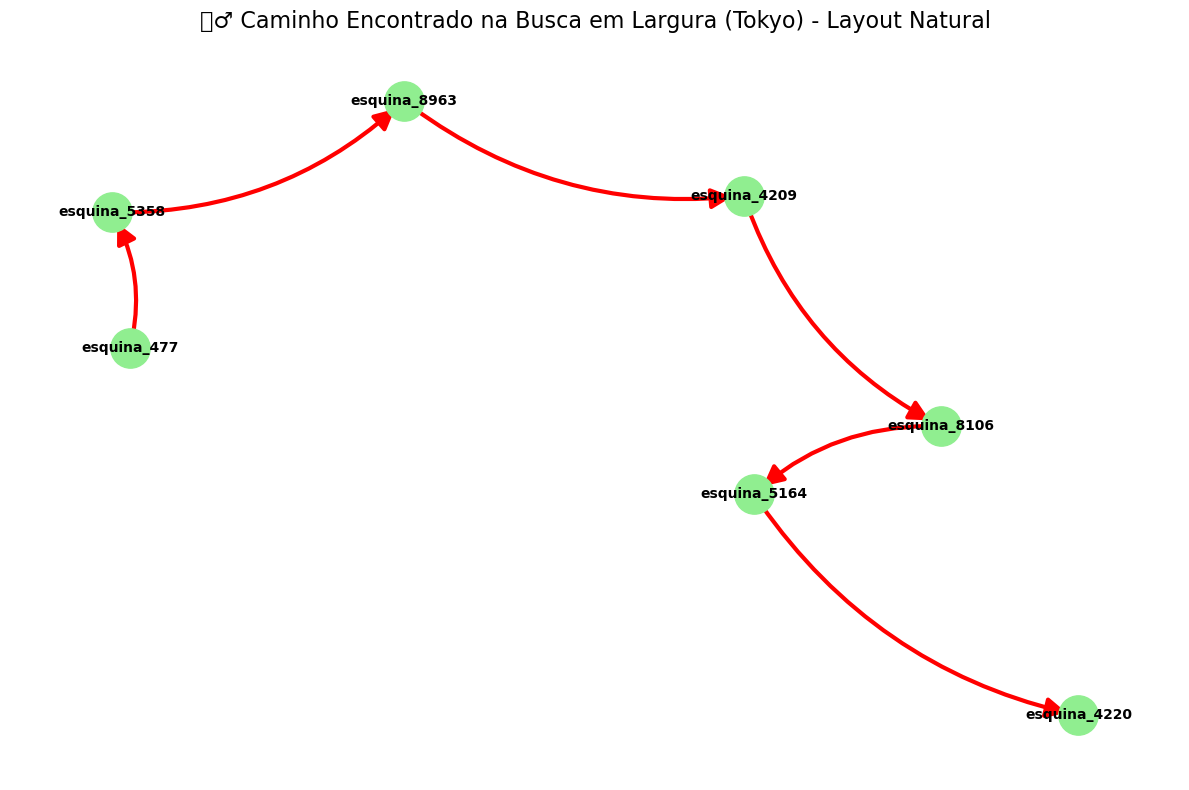

In [46]:
# (1) Extrair caminho do BFS
try:
    bfs_result = caminho_bfs_tokyo.first().asDict()
except Exception:
    bfs_result = {
        "from": {"id": "esquina_0"},
        "e0": {"src": "esquina_0", "dst": "esquina_1"},
        "v1": {"id": "esquina_1"},
        "e1": {"src": "esquina_1", "dst": "esquina_2"},
        "v2": {"id": "esquina_2"},
        "e2": {"src": "esquina_2", "dst": "esquina_3"},
        "to": {"id": "esquina_3"},
    }

# (2) Montar lista de arestas e vértices
arestas_caminho = []
vertices_caminho = []

i = 0
while True:
    try:
        e = bfs_result[f"e{i}"]
        arestas_caminho.append((e["src"], e["dst"]))
        if i == 0:
            vertices_caminho.append(e["src"])
        vertices_caminho.append(e["dst"])
        i += 1
    except KeyError:
        break

# (3) Criar o grafo
G_caminho = nx.DiGraph()
G_caminho.add_edges_from(arestas_caminho)

# (4) Layout natural com spring_layout
pos = nx.spring_layout(G_caminho, seed=42, k=0.5)  
# k controla a distância entre nós (menor = mais compacto)

# (5) Plotar
plt.figure(figsize=(12, 8))

# Nós
nx.draw_networkx_nodes(G_caminho, pos, node_color='lightgreen', node_size=800)

# Arestas com flechas grandes
nx.draw_networkx_edges(
    G_caminho, pos,
    edge_color='red', width=3,
    arrows=True, arrowsize=30, connectionstyle='arc3,rad=0.2'
)

# Labels
nx.draw_networkx_labels(G_caminho, pos, font_size=10, font_weight='bold')

plt.title("🚶‍♂️ Caminho Encontrado na Busca em Largura (Tokyo) - Layout Natural", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [50]:
grau_vertices = grafo_tokyo.degrees.toPandas()

             id  degree
0  esquina_8313       5
1  esquina_4236       6
2  esquina_5111       6
3  esquina_3134       9
4  esquina_7817       9


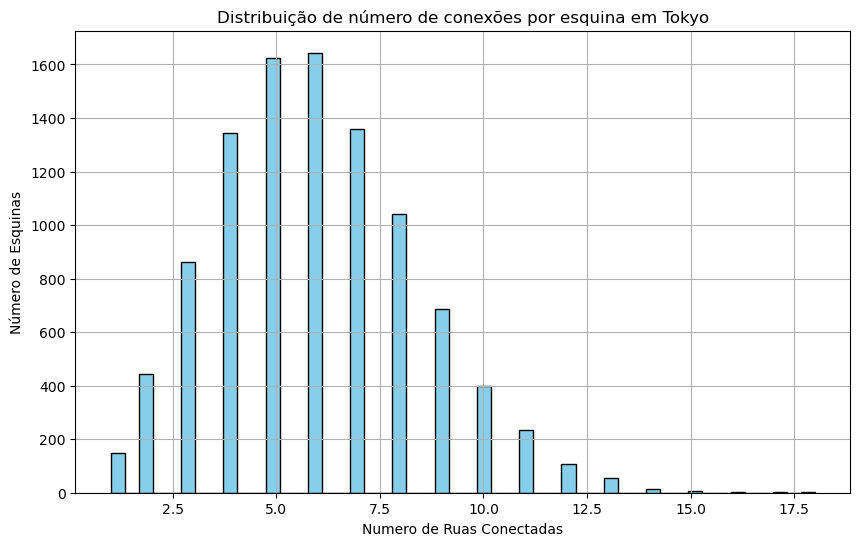

In [53]:
print(grau_vertices.head())
plt.figure(figsize=(10,6))
plt.hist(grau_vertices['degree'],bins=50,color='skyblue',edgecolor='black')
plt.title("Distribuição de número de conexões por esquina em Tokyo")
plt.xlabel("Numero de Ruas Conectadas")
plt.ylabel("Número de Esquinas")
plt.grid(True)
plt.show()

In [56]:
spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")

In [57]:
bairros_tokyo = grafo_tokyo.connectedComponents()

In [59]:
bairros_tokyo.select("id", "component").show(10)

+---------+---------+
|       id|component|
+---------+---------+
|esquina_0|        0|
|esquina_1|        0|
|esquina_2|        0|
|esquina_3|        0|
|esquina_4|        0|
|esquina_5|        0|
|esquina_6|        0|
|esquina_7|        0|
|esquina_8|        0|
|esquina_9|        0|
+---------+---------+
only showing top 10 rows



In [61]:
num_bairros = bairros_tokyo.select("component").distinct().count()
print(f"Numero de bairros isolados encontrados: {num_bairros}")

Numero de bairros isolados encontrados: 24


In [ ]:
components_top3 = components